In [41]:
import tensorflow as tf
import pandas as pd
import json
import os
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="grpc://" + os.environ["COLAB_TPU_ADDR"])
#Connect to the TPU handle and initialise it
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

INFO:tensorflow:Initializing the TPU system: grpc://10.9.86.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.9.86.242:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


In [42]:
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [43]:
import json

In [45]:
! ls

sample_data  Sarcasm_Headlines_Dataset.json  Sarcasm_Headlines_Dataset_v2.json


In [46]:
datastore = []
with open("Sarcasm_Headlines_Dataset.json", 'r') as f:
  for l in f.readlines():
    datastore.append(json.loads(l))

# with open("Sarcasm_Headlines_Dataset_v2.json", 'r') as f:
#   datastore2 = json.load(f) 


In [47]:
with open("Sarcasm_Headlines_Dataset_v2.json", 'r') as f:
  for l in f.readlines():
    datastore.append(json.loads(l))

In [48]:
sentences = []
labels = []
urls = []
for item in datastore:
  sentences.append(item["headline"])
  labels.append(item["is_sarcastic"])


In [49]:
import re
import string
def pad_punctuation(s): return re.sub(f"([{string.punctuation}])", r' \1 ', s)

sentences = [pad_punctuation(s) for s in sentences]

In [50]:
sentences[:10]

["former versace store clerk sues over secret  ' black code '  for minority shoppers",
 "the  ' roseanne '  revival catches up to our thorny political mood ,  for better and worse",
 "mom starting to fear son ' s web series closest thing she will have to grandchild",
 'boehner just wants wife to listen ,  not come up with alternative debt - reduction ideas',
 'j . k .  rowling wishes snape happy birthday in the most magical way',
 "advancing the world ' s women",
 'the fascinating case for eating lab - grown meat',
 'this ceo will send your kids to school ,  if you work for his company',
 'top snake handler leaves sinking huckabee campaign',
 "friday ' s morning email :  inside trump ' s presser for the ages"]

In [51]:
print(len(sentences), len(labels))

55328 55328


In [52]:
vocab_size = 30000
embedding_dim = 16
max_length = 150
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_ratio = 0.8

In [53]:
training_size = int(len(sentences) * training_ratio)

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

print(len(training_sentences), len(testing_sentences), len(training_labels), len(testing_labels), training_size)

44262 11066 44262 11066 44262


In [54]:
tokenizer = Tokenizer(oov_token=oov_tok, num_words=vocab_size, filters='#$%&()*+,-./:;<=>@[\\]^_{|}~\t\n')
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
print(len(word_index))

26083


In [55]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding=padding_type, truncating=trunc_type)

testing_sequence = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(training_padded.shape, testing_padded.shape, len(training_labels), len(testing_labels))

(44262, 150) (11066, 150) 44262 11066


In [56]:
with strategy.scope():
  model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
                             tf.keras.layers.Dense(24, activation = "relu"),
                             tf.keras.layers.Dense(1, activation = "sigmoid")
  ])
  model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 150, 16)           480000    
_________________________________________________________________
dropout_9 (Dropout)          (None, 150, 16)           0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 150, 128)          41472     
_________________________________________________________________
dropout_10 (Dropout)         (None, 150, 128)          0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 150, 64)           41216     
_________________________________________________________________
dropout_11 (Dropout)         (None, 150, 64)           0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 32)               

In [57]:
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch, logs={}):
    acc = logs.get("accuracy")
    print("Acc is ", acc)
    if acc > 0.988:
      print("Training Stop")
      self.model.stop_training = True
callback = MyCallback()

In [58]:
num_epochs = 25
print(training_labels)
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)

testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

history = model.fit(training_padded, training_labels, validation_data = (testing_padded, testing_labels), epochs=num_epochs)


[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 

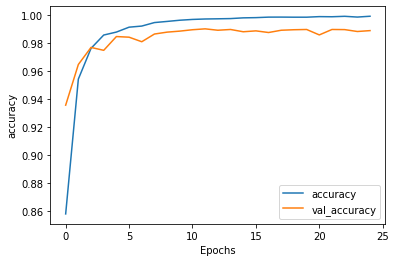

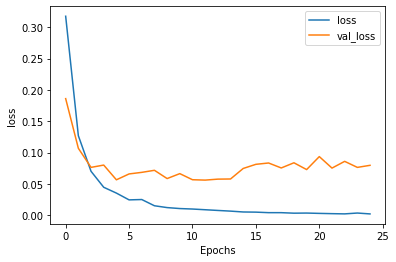

In [20]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [59]:
! pip install tensorflowjs

     |████████████████████████████████| 64 kB 2.2 MB/s 


In [60]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, "jsModel")

In [61]:
model.save("tfModel.h5")

In [25]:
from google.colab import files
files.download("tfModel.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
! ls

jsModel      Sarcasm_Headlines_Dataset.json	tfModel.h5
sample_data  Sarcasm_Headlines_Dataset_v2.json


In [27]:
! tar -czvf jsModelfile.tar.gz jsModel

jsModel/
jsModel/group1-shard1of1.bin
jsModel/model.json


In [28]:
files.download("jsModelfile.tar.gz")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
fil = open("word_index.json", "w")
len(word_index)

26083

In [30]:
json.dump(word_index, fil)

In [31]:
fil.close()

In [32]:
files.download("word_index.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>